# Import Statements

In [1]:
import pandas as pd
import pyodbc
import cx_Oracle
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from IPython.display import display, Markdown


pd.set_option("display.max_columns", 999)
pd.set_option('display.max_rows', 500)
pd.set_option("display.expand_frame_repr",True)
pd.set_option("display.max_colwidth", 100)

In [2]:
folder = r"C:\Users\armando_borjas\Documents"
%cd $folder
%ls

C:\Users\armando_borjas\Documents
 Volume in drive C has no label.
 Volume Serial Number is FE48-FC0C

 Directory of C:\Users\armando_borjas\Documents

2020-08-13  04:15 PM    <DIR>          .
2020-08-13  04:15 PM    <DIR>          ..
2020-08-12  11:33 AM    <DIR>          Archived Work
2020-08-10  02:26 PM    <DIR>          Custom Office Templates
2020-04-01  12:59 PM         1,085,868 Demo.pbix
2019-12-11  09:13 AM    <DIR>          Downloads
2019-10-29  08:19 AM    <DIR>          Dynamic Risk
2020-08-13  04:14 PM        38,514,339 Full_System_Hazard_radius_data_July_28_2020_Occupancy.xlsx
2020-02-06  05:18 PM    <DIR>          GIS DataBase
2019-12-09  11:37 AM    <DIR>          My Received Files
2020-07-28  08:55 AM    <DIR>          NGL2009-2019
2019-11-29  01:58 PM    <DIR>          OneNote Notebooks
2020-05-27  11:14 AM        15,309,236 PMC - Quantitative Risk Update_20190114.pptx
2020-08-10  02:26 PM         4,807,003 PMC ILI Sentencing Algorithm Instructions.docx
2020-04-24  0

# Functions

In [2]:
def sqlserver_sql(q, server = 'SQL2017', db = 'IPL_IRASV6_STAGE'):
    driver = '{SQL Server Native Client 11.0}'
    conn = pyodbc.connect("Driver="+driver+";Server="+server+";Database="+db+";Trusted_Connection=yes;")

    # performing query to database
    df = pd.read_sql_query(q,conn)

    conn.close()
    return df


def oracle_sql(q,user=r'ATCO_IRASV5_STAGE', password='atco', dsn='ORA12C'):
    conn = cx_Oracle.connect(user, password, dsn)

    t_data = pd.read_sql_query(q,conn)

    conn.close()
    
    return t_data

In [3]:
def get_ili_ranges(line):
    q1 = f"""set nocount on;
            select ll.LineName, ld.code [status], r.* from InlineInspectionRange r
            join StationSeries ss on r.BeginStationSeriesId = ss.Id
            join LineLoop ll on ss.LineLoopId = ll.Id
            join ListDomain ld on r.ILIRStatusDomainId = ld.Id
            where ll.LineName like '%{line}%'
            order by r.ILIRStartDate desc"""

    return sqlserver_sql(q1)

In [4]:
def build_df(od_i, wt_mm, grade_mpa, maop_kpa, installdate, ILIdate, pdf, lengthmm, create=True, **kwargs):
    if create:
        temp_dict = dict(OD_inch=[od_i],
                        WT_mm=[wt_mm],
                        grade_MPa=[grade_mpa],
                        install_date=[installdate],
                        MAOP_kPa=[maop_kpa],
                        ILIRStartDate=[ILIdate],
                        depth_fraction=[pdf],
                        length_mm=[lengthmm]
                        )
            
        return pd.DataFrame(temp_dict)
    else:
        temp_df = pd.DataFrame(dict(OD_inch=[od_i],
                        WT_mm=[wt_mm],
                        grade_MPa=[grade_mpa],
                        install_date=[installdate],
                        MAOP_kPa=[maop_kpa],
                        ILIRStartDate=[ILIdate],
                        depth_fraction=[pdf],
                        length_mm=[lengthmm]
                        ))
        return kwargs['df'].append(temp_df)

In [5]:
def get_features_for_poe(ILIRID, start=1, amt=999999999):
    query = f"""select
            c.RN,
            ll.linename [line],

            ld4.code [vendor], 

            format(r.ILIRStartDate,'yyyy-MM-dd') [ILIRStartDate],
            ld3.code [tool],

            f.ILIFFeatureNumber [FeatureID],
            ld.code [status], 
            ld2.code [type],
            (f.StationNum*mlv.MultiplierNum+mlv.FactorNum) [chainage_m], 
            f.ILIFSurfaceInd, 
            f.ILIFPeakDepthPct [depth_fraction], 
            f.ILIFLength [length_mm], 
            f.ILIFWidth [width_mm], 

            format(a.PipeInserviceDate,'yyyy-MM-dd') [install_date],
            a.PipeOutsideDiameter [OD_inch],
            a.PipeWallThickness [WT_mm],
            a.PipeGrade [grade_MPa],
            a.PipeToughness [toughness_J],
            a.[begin_ps_c],
            a.[end_ps_c],

            b.MAOP_kPa,
            b.begin_maop_c,
            b.end_maop_c  

            from InlineInspectionFeature f

            left join ListDomain ld on f.ILIFStatusDomainId = ld.Id
            left join ListDomain ld2 on f.ILIFTypeDomainId = ld2.Id
            left join StationSeries ss on f.StationSeriesId = ss.id
            left join LineLoop ll on ss.LineLoopId = ll.Id
            left join inlineinspectionrange r on f.inlineinspectionrangeid = r.id
            left join ListDomain ld3 on r.ILIRToolDomainId = ld3.Id
            left join InlineInspection i on f.InlineInspectionId = i.Id
            left join ListDomain ld4 on i.ILICompanyDomainId = ld4.Id
            left join MLVCorrection mlv on f.StationSeriesId = mlv.StationSeriesId

            left join 
                (select ll.id [LinloopId],
                ll.LineName,
                ps.EffectiveStartDate,
                ps.PipeInserviceDate,
                ps.PipeOutsideDiameter,
                ps.PipeWallThickness,
                ps.PipeGrade,
                ps.PipeToughness,
                (ps.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum) [begin_ps_c],
                (ps.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum) [end_ps_c]
                from PipeSegment ps
                join StationSeries ss on ps.BeginStationSeriesId = ss.id
                join LineLoop ll on ss.LineLoopId = ll.Id
                join MLVCorrection mlv1 on ps.BeginStationSeriesId = mlv1.StationSeriesId
                join MLVCorrection mlv2 on ps.EndStationSeriesId = mlv2.StationSeriesId
                where ps.EffectiveEndDate is null
                ) a on ((f.StationNum*mlv.MultiplierNum+mlv.FactorNum) between a.[begin_ps_c] and a.[end_ps_c]) and a.LinloopId = ll.id

            left join 
                (select ll.id [LinloopId],
                ll.LineName,
                maop.EffectiveEndDate,
                maop.BeginStationSeriesId,
                maop.MaxAllowablePressure [MAOP_kPa],
                maop.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum [begin_maop_c],
                maop.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum [end_maop_c]
                from maop maop
                join StationSeries ss on ss.id = maop.BeginStationSeriesId
                join LineLoop ll on ss.LineLoopId = ll.Id
                join MLVCorrection mlv1 on maop.BeginStationSeriesId = mlv1.StationSeriesId
                join MLVCorrection mlv2 on maop.EndStationSeriesId = mlv2.StationSeriesId
                where maop.EffectiveEndDate is null
                ) b on ((f.StationNum*mlv.MultiplierNum+mlv.FactorNum) between b.[begin_maop_c] and b.[end_maop_c]) and b.[LinloopId] = ll.id 

            left join
                (select ROW_NUMBER() over(partition by ff.InlineInspectionRangeId order by ff.id asc)  [RN],
                ff.id,
                ff.InlineInspectionRangeId
                from InlineInspectionFeature ff
                )  c on f.Id = c.Id and f.InlineInspectionRangeId = c.InlineInspectionRangeId

            where f.InlineInspectionRangeId = {ILIRID} and (c.RN between {start} and {start+amt})
            order by chainage_m asc"""
    
    return sqlserver_sql(query)

In [6]:
def check_table_overlap(table, user=r'ATCO_IRASV5_STAGE', password='atco', dsn='ORA12C'):
    # query for table to check for overlaps
    q1 = f"""set nocount on;
            select e.Id [RecordId],
            (mlv1.MultiplierNum*e.BeginStationNum+mlv1.FactorNum) [eBeginChainage],
            (mlv2.MultiplierNum*e.EndStationNum+mlv2.FactorNum) [eEndChainage], e.* from {table} e
            join MlvCorrection mlv1 on mlv1.StationSeriesId = e.BeginstationSeriesId
            join MlVcorrection mlv2 on mlv2.StationseriesId = e.EndStationSeriesId"""

    df2 = oracle_sql(q1, user=user, password=password, dsn=dsn)

    # sorting in increasing stationseriesid and chainage
    df2 = df2.sort_values(by=['BeginStationSeriesId','eBeginChainage']).reset_index(drop=True)

    # creating subset containing only the chainages
#     ss_df2 = df2[['BeginStationSeriesId','eBeginChainage','EndStationSeriesId','eEndChainage']]

    # following pandas statement displays the subtraction from one record's endchainage to the next records beginchainage
#     ss_df2.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x: x['eBeginChainage'].shift(-1)-x['eEndChainage']).fillna(0.00)

    # following statements filter out anything that doesn't have an overlap
#     ss_df2_overlaps = ss_df2.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x: x['eBeginChainage'].shift(-1)-x['eEndChainage']).reset_index(name='record_diff').fillna(0.00)
    
    df2 = df2.join(df2.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x:  x['eBeginChainage'].shift(-1)-x['eEndChainage']).reset_index(name='record_diff').fillna(0.00).record_diff)
    return df2[df2.columns.values[[0,1,2,-1]+[x for x in range(3,len(df2.columns)-1)]]]#.query("record_diff != 0.")

In [7]:
def check_table_span(table,  user=r'ATCO_IRASV5_STAGE', password='atco', dsn='ORA12C'):
    # query for the table to check if records fall within bounds of stationseries
    q2 = f"""set nocount on;
            select ss.lineloopid [LineLoopId],
            (mlv1.MultiplierNum*e.BeginStationNum+mlv1.FactorNum) [eBeginChainage],
            (mlv2.MultiplierNum*e.EndStationNum+mlv2.FactorNum) [eEndChainage], e.* from {table} e
            join MlvCorrection mlv1 on mlv1.StationSeriesId = e.BeginstationSeriesId
            join MlVcorrection mlv2 on mlv2.StationseriesId = e.EndStationSeriesId
            join stationseries ss on e.Beginstationseriesid = ss.id
            """

    q3 = f"""set nocount on;
            select 
            (mlv.MultiplierNum*ss.BeginStationNum+mlv.FactorNum) [sBeginChainage],
            (mlv.MultiplierNum*ss.EndStationNum+mlv.FactorNum) [sEndChainage], ss.* from stationseries ss
            join MlvCorrection mlv on mlv.StationSeriesId = ss.id
            """

    df3 = oracle_sql(q2, user=user, password=password, dsn=dsn)
    df4 = oracle_sql(q3, user=user, password=password, dsn=dsn)

    # this next statement just aggregates the event table data and shows the span of the data. DOESN'T PICK OUT GAPS.
    # df3.groupby("LineLoopId").agg({'eBeginChainage':'min','eEndChainage':'max'})


    return df4.groupby("LineLoopId").agg({'sBeginChainage':'min','sEndChainage':'max'}).join(df3.groupby("LineLoopId").agg({'eBeginChainage':'min','eEndChainage':'max'})).assign(delta_end = lambda x: x.sEndChainage-x.eEndChainage,
                                                                                                                                                                                    delta_begin = lambda x: x.sBeginChainage-x.eBeginChainage).query("(delta_end!=0.) | (delta_begin!=0.)")

In [8]:
def impact_fault_tree(b1,b2,b3,b4,b5,b7,b9,b10,b11,b12,b6=0.40,b8=0.97):
    res = b1 * b12 * (1 - ((1-(1 - ((1-(b7 * b8 * (1 - ((1-(b2 * b3 * b4)) * (1-(b5 * b6)))))) * (1-(b4 * (1 - ((1-(b6 * b9)) * (1-(b6 * b10))))))))) * (1-b11)))
    return res

round(impact_fault_tree(0.03,0.24,0.23,1.,0.33,0.52,0.2,0.09,0.03,0.87),6) == 0.005684

True

In [26]:
# q = """
#         select 
#         ld.id as ListDomainId,
#         ld.domaincatalogid as DomainCatalogId,
#         ld.code as ListDomainCode,
#         NULL as EC,
#         NULL as IC
#         from ListDomain ld
#         --join domaincatalogcolxref xr on ld.domaincatalogid = xr.domaincatalogid
#         --where xr.columnname = 'ILICATypeDomainId'
#         where ld.domaincatalogid = 254
        
#         """

q = """
        select
        ld.code,
        ps.*
        from pipesegment ps
        join listdomain ld on ps.pipemanufacturerdomainid = ld.id
        where ps.effectiveenddate is null"""

df = oracle_sql(q)
df['length'] = df.ENDSTATIONNUM-df.BEGINSTATIONNUM
df['PIPEINSERVICEDATE'] = pd.to_datetime(df['PIPEINSERVICEDATE'])
display(df.groupby('CODE')['length'].sum())

CODE
ABPX              199917.359
ALTPX                856.260
AbPhnx            199917.359
Alta Phoenix         856.260
CAMRZ              12065.600
CANPX                940.265
CP                  2584.709
CamPipe             2584.709
Camrose            12065.600
CanPhnx              940.265
IPSCO              90018.296
MARITTUB             182.000
MRITB                182.000
N/A              8252433.636
NDSTM                  2.700
NPN                   94.200
Nippon                94.200
PGHRSY              1645.440
PRDL               11547.565
Prudentl           11547.565
RSTL                2368.400
RamSteel            2368.400
SDRHM             146212.924
SDurham           146212.924
TD WILLIAMSON          2.700
TNARS                452.860
Tenaris              452.860
UGL NORDSTROM          2.700
UNK              8696277.100
UNKNOWN          1228661.012
Name: length, dtype: float64

In [27]:
df.groupby(df['PIPEINSERVICEDATE'].dt.year)['length'].sum()

PIPEINSERVICEDATE
1922.0         27.510
1930.0       1171.150
1943.0      16112.320
1945.0      12542.472
1946.0      16117.520
1947.0       2085.340
1948.0      20869.220
1949.0      25072.150
1950.0      58448.720
1951.0     120961.367
1952.0      35665.900
1953.0      67348.760
1954.0      67552.340
1955.0      72117.770
1956.0     496295.775
1957.0      32396.940
1958.0     201786.234
1959.0     177768.670
1960.0      89743.010
1961.0      50326.911
1962.0       5602.790
1963.0       7284.530
1964.0     174977.870
1965.0      13556.555
1966.0      35461.590
1967.0     173629.480
1968.0      46261.720
1969.0      55451.327
1970.0      40633.800
1971.0      63449.850
1972.0      33615.230
1973.0      24937.663
1974.0     106065.350
1975.0     199352.883
1976.0     172987.712
1977.0      90315.127
1978.0      94231.691
1979.0      25040.872
1980.0      32754.610
1981.0     146152.380
1982.0      76203.730
1983.0      97965.073
1984.0       4121.470
1985.0      91716.866
1986.0      26

# Risk Results Review

## QC Preparation 

In [11]:
%%time
# results = pd.read_csv(r"202003133-worsley_rossdale_results.csv",
#                       encoding='utf-8',
#                       header=0,
#                       skiprows=3,
#                      warn_bad_lines=False)

results = pd.read_excel(r"",skiprows=3, header=0)
results.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3963 entries, 0 to 3962
Columns: 229 entries, Matrix to Total Probability x Total Consequence
dtypes: datetime64[ns](2), float64(145), int64(65), object(17)
memory usage: 10.6 MB
Wall time: 6.8 s


In [12]:
results.head()

,Matrix,Segment,Route,Start Chainage (m),End Chainage (m),Length (m),Outside Diameter (mm),Wall Thickness (mm),MAOP (kPa ),Grade (MPa),Pipe Material,Installation Year,Material Factor,Pipe Coating Install Year,Age Factor,Corrosion Allowance (mm),Corrosion Allowance Factor,Mainline Coating,Mainline Coating Type Score,Total Non-Conformance Readings,Total All Readings,CP System Not Operable (%),CP Compliance Score,Soil Type,Soil Land Use,Soil Aggressiveness Score,EC Incident,Incident Remediation,Failure History Score,Baseline Susceptibility Score,Stray Current Description,Stray Current Factor,Date of last ECDA,Date of last Hydro Retest,Integrity Assessment Mitigation Factor,"EC Score, no ILI",Date of last ILI (MFL),ILI Range Status,ILI Segment Length (m),External ILI Features,"Minimum Failure Pressure, External (kPa )",Failure Pressure Ratio,Operating Stress Level,Growth Rate GrowthRate (mm/yr),Growth Rate Factor,Maximum Response Time (yrs),"EC Score, ILI",External Corrosion (22%),Outside Diameter (mm).1,Wall Thickness (mm).1,MAOP (kPa ).1,Operating Temperature (°C),Grade (MPa).1,Installation Year.1,% SMYS,Proximity to Station,Mainline Coating.1,Exposed Pipe Description,Near-neutral pH Susceptibility Score,Near-neutral pH Stress Level Score,Near-neutral pH Coating Design Score,Near-neutral pH Age Score,Near-neutral pH Factored Bias Score,FBE Factor,Near-neutral pH SCC Failures,Near-neutral pH SCC Severe Findings,Near-neutral pH SCC Non-Severe Findings,Near-neutral pH History Score,Near-neutral pH Bias Score,Date of last ILI (crack),Date of last Hydro Retest.1,Near-neutral pH Multiplication Factor,Near-neutral pH SCC Score,High pH Susceptibility Score,High pH Stress Level Score,High pH Coating Design Score,High pH Proximity to Station Score,High pH Age Score,Maximum Temperature in Past Year (°C),High pH Temperature Score,High pH Factored Bias Score,Proximity Susceptibility Factor,High pH SCC Failures,High pH SCC Severe Findings,High pH SCC Non-Severe Findings,High pH SCC History Score,High pH Bias Score,High pH Multiplication Factor,High pH SCC Score,Stress Corrosion Cracking (2%),Outside Diameter (mm).2,Wall Thickness (mm).2,MAOP (kPa ).2,Grade (MPa).2,Toughness ( ),Pipe Material.1,B1 - Pipe Location,B2 - Public Awareness,B3 - Signage,B4 - Markers,B5 - 3rd Party Notificati,B7 - Patrol Frequency,B9 - Response Time,B10 - Pipe Finding,B11 - Marking,B12 - Depth of Cover (m),Impact Frequency (/km.yr),Impact Frequency Score,Critical Force (kN),"Fail Susceptibility, Given a Hit Score",3rd Party Damage (41%),Outside Diameter (mm).3,Wall Thickness (mm).3,MAOP (kPa ).3,Grade (MPa).3,Pipe Manufacturer,Seam Type,Installation Year.2,Presence of Hard Spot,Susceptibility to Hard Spots Score,%SMYS,Stress Level Score,"Total On/Off, Off < -1.2V",Total On/Off CP Readings,"CP On, On<-1.25V",Total ON Only CP Readings,Cathodic Protection Score,Hard Spot Susceptibility Score,Hard Spot Repair Description,Repair Score,Hard Spot Score,Susceptible Pipe Analysis,In-Service ERW Weld Failure,Failure Since Hydrotest,Hydro Retest Pressure (kPa ),125% MOAP (kPa ),150% MAOP (kPa ),Pressure at 30% SMYS (kPa ),Pressure at 40% SMYS (kPa ),LF and DC-ERW Score,In-Service Lap Weld Failure,Lap Weld Score,In-Service Butt Weld Failure,MD Butt Wled Score,In-Service Hammer Weld Failure,Hammer Weld Score,Increase in MAOP,OP Increase above 5yr Pressure,Pressure Cycle,MD Interacting Threats,Previous Assessments indicating MD,Assessment Potentially Required,Seam Defect Score,Manufacturing Defect (30%),Installation Year.3,Buried Coupling Presence,Coupling Susceptibility Factor,Coupling Reinforcement,Coupling Reinforcement Factor,Coupling Score,OxyWeld,Welding,Weld Failures,Weld Susceptibility Factor,% Girth Welds Inspected (%),X-Ray Factor,Girth Weld Score,Geotechnical Threat Score,Construction Threat (5%),Unstable Slope SME,Unstable Slope Remediation,Unstable Slope Score,Flooding SME assessment assessment,Flooding Ranking,Flooding Remediation,Flooding Threat Score,Surface Loadin

Querying the LineLoop table from database

In [13]:
q1 = """select ps.PipelineSystemName, ll.id as LineID, ll.LineName from lineloop ll
        join pipelinesystem ps on ll.pipelinesystemid = ps.id
       where ll.LineName in ('71-5',
                            '101-601',
                            '71-13',
                            '71-2',
                            '101-501',
                            '71-6',
                            '71-11',
                            '71-4',
                            '101-114',
                            '101-301',
                            '101-9201',
                            '101-9301',
                            '71-1',
                            '101-201',
                            '342-1',
                            '101-801',
                            '101-122',
                            '101-401',
                            '71-3',
                            '95-1')"""
ll_table = oracle_sql(q1)
# ll_table.groupby('PipelineSystemName').count()
ll_table

,PIPELINESYSTEMNAME,LINEID,LINENAME
0,WORSLEY-MCLENNAN TRANSMISSION,810031505,101-9301
1,WORSLEY-MCLENNAN TRANSMISSION,810031503,101-801
2,WORSLEY-MCLENNAN TRANSMISSION,810031502,101-601
3,WORSLEY-MCLENNAN TRANSMISSION,810035574,101-114
4,WORSLEY-MCLENNAN TRANSMISSION,810030411,101-501
5,WORSLEY-MCLENNAN TRANSMISSION,810030839,101-122
6,WORSLEY-MCLENNAN TRANSMISSION,810030838,101-9201
7,WORSLEY-MCLENNAN TRANSMISSION,810030836,101-401
8,WORSLEY-MCLENNAN TRANSMISSION,810030835,101-301
9,WORSLEY-MCLENNAN TRANSMISSION,810030832,101-201


Converting LineID column to int64.
Setting index to LineID

In [14]:
ll_table.loc[:,'LINEID'] = ll_table.LINEID.astype('int64')
ll_table.set_index('LINEID', inplace=True)
ll_table

,PIPELINESYSTEMNAME,LINENAME
LINEID,,
810031505,WORSLEY-MCLENNAN TRANSMISSION,101-9301
810031503,WORSLEY-MCLENNAN TRANSMISSION,101-801
810031502,WORSLEY-MCLENNAN TRANSMISSION,101-601
810035574,WORSLEY-MCLENNAN TRANSMISSION,101-114
810030411,WORSLEY-MCLENNAN TRANSMISSION,101-501
810030839,WORSLEY-MCLENNAN TRANSMISSION,101-122
810030838,WORSLEY-MCLENNAN TRANSMISSION,101-9201
810030836,WORSLEY-MCLENNAN TRANSMISSION,101-401
810030835,WORSLEY-MCLENNAN TRANSMISSION,101-301


Merging LineLoop query to the results.

In [ ]:
%%time
results = pd.merge(results,ll_table, how='inner', left_on="LineID", right_index=True, suffixes=('','_db'), indicator=True)#.loc[:,:]

Count of pipelines for assurance check.

In [ ]:
results.groupby('PipelineSystemName').LineID.nunique()

In [ ]:
tsl = results.ds_length.sum()

## QC Start

In [16]:
display(results.columns.to_frame().rename(columns={0:'cols'}).query("cols.str.contains('.\d$')").sort_values(by='cols'))
results.drop(columns=results.columns.to_frame().rename(columns={0:'cols'}).query("cols.str.contains('.\d$')").cols.values, inplace=True)

,cols


In [134]:
display(Markdown("# Object Variable Data Summary"))
results.info()
results.filter(like='Land').describe(include='all').T.loc[lambda x: x['count'] > 0]

# Object Variable Data Summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3963 entries, 0 to 3962
Columns: 189 entries, Matrix to Total Probability x Total Consequence
dtypes: datetime64[ns](1), float64(114), int64(61), object(13)
memory usage: 5.7+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Soil Land Use,3962,3,All Others (default),3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Land Use,3962,5,Low Density Residential,1558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Environmental Land Use Score,3963,NaN,NaN,NaN,2.75902,0.443947,2,3,3,3,10


In [ ]:
# col = 'Pipe Manufacturer'
# col2 = 'MAOP (kPa )'
# display(Markdown(f"# {col}"))

# f_null = lambda x: x[col].isnull()
# f_qa = lambda x: x[col] < x[col2]

# display(Markdown(f"{results.loc[f_null].shape[0]} records with NULL '{col}'"))

# data_rep = results.loc[f_null,results.columns[:6].append(pd.Index([col]))]
# display(data_rep)

# # data_rep.to_csv(''.join(e for e in col if e.isalnum())+'.csv')
# # del data_rep

# # data_qa = results.loc[f_qa,results.columns[:6].append(pd.Index([col,col2]))]
# # display(Markdown(f"{data_qa.shape[0]} records with {col} < {col2}"))
# # display(data_qa)

# # data_qa.to_csv('QA_'+''.join(e for e in col if e.isalnum())+'.csv')
# # del data_rep

# data_dist = results.groupby(col).sum()['Length (m)'].to_frame()
# display(data_dist)

# # data_dist.to_csv('DIST_'+''.join(e for e in col if e.isalnum())+'.csv')
# # del data_dist


In [ ]:
pd.DataFrame(results.columns, columns=['col']).query("col.str.contains('public', case=False)")

In [ ]:
def pct_error(col1,col2):
    return abs(col1 - col2)*100./col2

# ## results.assign(qc = lambda x: x.Impact_Frequency_perkmyr*x.MD_Past_Incidents_Multiplier*x.Probability_of_Failure_Given_a_Hit,
#               pct_error = lambda x: abs(x.qc - x.Mechanical_Damage_Failure_Frequency_perkmyr)*100./x.Mechanical_Damage_Failure_Frequency_perkmyr).loc[:,['qc','Mechanical_Damage_Failure_Frequency_perkmyr','pct_error']].describe()

# ## checking for nulls
# results.loc[:,['Maximum_Operating_Pressure_PSI',
#                'Outside_Diameter_Inch',
#                'Wall_Thickness_Inch',
#                'Grade_KSI',
#                'ds_length']].fillna(-1).loc[lambda x: (x.Grade_KSI == -1),:].ds_length.sum()*100/tsl

results.loc[:,['Class_Area_Location',
               'HCA_Identified_Site_count',
               'HCA_GT20_Buildings_count',
               'PD2',
               'Public_Impact_Class',
               'Public_Impact_HCA',
               'Public_Impact',
              'ds_length']].assign(bucket = lambda x: pd.cut(x.PD2, [-np.inf,
                                                                     116000,
                                                                     170000,
                                                                     210000,
                                                                     244000,
                                                                     275000,
                                                                     303000,
                                                                     327000,
                                                                     351000,
                                                                     372500,
                                                                     np.inf])).groupby(['Class_Area_Location','bucket']).Public_Impact_Class.describe()

## QC of POE (EC/IC) 

In [ ]:
def critical_depth_modified_b31g(od, wt, s, p, fL, units="SI"):
    """
    Calculates the failure stress using the Modified B31G Equation
    :param od:  Pipe outside diameter, in mm (SI), or inches (US)
    :param wt:  Pipe wall thickness, in mm (SI), or inches (US)
    :param s:   Pipe grade, in kPa (SI), or psi (US)
    :param p:   pressure, in kPa (SI), or psi (US)
    :param fL:  feature length, in mm (SI), or inches (US)
    :param units: flag for which units to use, "SI" or "US", default "SI"
    :return: Critical depth, in mm (SI), or inches (US)
    """

    l2Dt = np.power(fL, 2.0)/(od*wt)
    Mt = np.where(l2Dt <= 50.0,
                  np.sqrt( 1.0 +(0.6275*l2Dt)-(0.003375*np.power(l2Dt, 2.0))),
                  0.032*l2Dt+3.3)
    if units=="SI":
        flowS = s + 68947.6
    else:
        flowS = s + 10000.0

    opStress = (p*od)/(2.*wt)
    
    critical_d = ((opStress-flowS)*wt)/(0.85*((opStress/Mt)-flowS))
#     return np.minimum(critical_d/wt,0.8)
    return critical_d

def statistical_poe(df, m_cgr=0.3048, sd_cgr=0.3048*0.25):
    ## CAUTION: Equation for now creates additional columns in the input dataframe
    # ILI Age in years
#     df = i_df.copy()
    df.loc[:,'ILI Age'] = (pd.datetime.today() - pd.to_datetime(df.loc[:,'ILIRStartDate'])).dt.days/365.25

    # Measured Depth in mm
    df.loc[:,'depth_run_mm'] = df.loc[:,'depth_fraction']*df.loc[:,'WT_mm']

    # Failure Depth in mm
    df.loc[:, 'failure_depth_mm'] = critical_depth_modified_b31g(df.loc[:,'OD_inch']*25.4, df.loc[:,'WT_mm'], df.loc[:,'grade_MPa']*1000., df.loc[:,'MAOP_kPa'], df.loc[:,'length_mm'])
    
    # Mean of Depth in mm
    df.loc[:,'mean_depth_mm'] = (df.loc[:,'WT_mm']*0.00) + df.loc[:,'depth_run_mm'] + (df.loc[:,'ILI Age']*m_cgr)
    
    # SD of Depth in mm
    df.loc[:,'sd_depth_mm'] = np.sqrt(  np.power(0.078*df.loc[:,'WT_mm'],2) +  np.power(df.loc[:,'ILI Age'],2) * np.power(sd_cgr, 2))
    
    df.loc[:,'leak_poe'] = 1.0 - norm.cdf(0.80*df.loc[:,'WT_mm'], loc=df.loc[:,'mean_depth_mm'], scale= df.loc[:,'sd_depth_mm'])
    df.loc[:,'rupture_poe'] = 1.0 - norm.cdf(df.loc[:,'failure_depth_mm'], loc=df.loc[:,'mean_depth_mm'], scale= df.loc[:,'sd_depth_mm'])

    return np.where(df.loc[:,'failure_depth_mm']/df.loc[:,'WT_mm']> 0.80, df.loc[:,'leak_poe'], df.loc[:,'rupture_poe'])


In [ ]:
get_ili_ranges("LS2000")

In [ ]:
qcdf = get_features_for_poe(276)

In [ ]:
pd.DataFrame(qcdf.columns, columns=['col']).query("col.str.contains('', case=False)")

In [ ]:
display(qcdf.assign(poe = statistical_poe(qcdf, m_cgr=0.0, sd_cgr=0.0*0.25),
                    pct_smys=lambda x: (x.MAOP_kPa*x.OD_inch*25.4)/(20*x.WT_mm*x.grade_MPa)).query("chainage_m.between(258.391,267.592) & ILIFSurfaceInd =='E'").drop_duplicates('FeatureID'))
1- np.prod(1 - qcdf.assign(poe = statistical_poe(qcdf, m_cgr=0.0, sd_cgr=0.0*0.25)).query("chainage_m.between(258.391,267.592) & ILIFSurfaceInd =='E'").drop_duplicates('FeatureID').poe)


In [ ]:
(50.0*4.78/(10*100))

## QC of Drain Factor

In [ ]:
def drain_factor(emin, emed, emax, eloc):
    temp_df = np.where(eloc.between(emin, emed), 1 - 0.5*((eloc-emin)/(emed-emin)),
                      0.5*((emax-eloc)/(emax-emed)))
    return temp_df

In [ ]:
drain_factor(pd.Series(675.84), pd.Series(698.28), pd.Series(718.23), pd.Series(702.33))

## QC of Release Rate Calculations

In [ ]:
def damage_area_sqft(product, release_rate_kgps):
    release_rate_lbps = release_rate_kgps*2.20462
    i_c = np.where(product == 'Natural Gas', 41.0,
                                  np.where(product == 'Ethane Plus', 28.,
                                          np.where(product == 'Condensate', 4.35,
                                                  np.where(product.isin(['Diluent','CLPL Diluent']), 3.3,
                                                           0.03))))
    
    i_p = np.where(product == 'Natural Gas', 0.67,
                              np.where(product == 'Ethane Plus', 0.72,
                                      np.where(product == 'Condensate', 0.78,
                                              np.where(product.isin(['Diluent','CLPL Diluent']), 0.76,
                                                       0.99))))
        
    c_c = np.where(product == 'Natural Gas', 43.0,
                          np.where(product == 'Ethane Plus', 49.48,
                                  np.where(product == 'Condensate', 182.0,
                                          np.where(product.isin(['Diluent','CLPL Diluent']), 130.,
                                                   11.0))))

    c_p = np.where(product == 'Natural Gas', 0.98,
                      np.where(product == 'Ethane Plus', 1.0,
                              np.where(product == 'Condensate', 0.89,
                                      np.where(product.isin(['Diluent','CLPL Diluent']), 0.90,
                                               0.91))))
    
    
    temp_area = np.where((release_rate_kgps)>25.20159, i_c*np.power(180.*release_rate_lbps,i_p),
                        c_c*np.power(release_rate_lbps,c_p))
    
    return temp_area

def release_rate_kgps(state, cp, density, mw, maop, t, hole_a):
    k = cp / (cp - 8.314)
    tp = 101.325*np.power( (k+1)/2 ,k/(k-1))
    t_K = t+273.15
    
    regime = np.where(maop > tp, 'supersonic', 'subsonic')
    
    temp_rel = np.where(state == 'Liquid', 0.62*hole_a*np.sqrt(2*density*maop*1000.),
                       np.where(regime=='supersonic',0.9*hole_a*maop*1000.*np.sqrt( ((k*mw)/(8314.4598*t_K))*np.power(2/(k+1), (k+1)/(k-1))),
                               0.9*hole_a*maop*1000.*np.sqrt( (mw/(8314.4598*t_K))*(2*k/(k-1))*np.power(101.325/maop, 2/k) * (1 - np.power(101.325/maop,(k-1)/k)))))
    
    return temp_rel

In [ ]:
# damage_area_sqft(pd.Series(['Ethane Plus']), pd.Series([9.44]))

# results.loc[:,['Product_Type','Release_Rate_kgpersec','Damage_Area_sqft']].assign(qc = lambda x: damage_area_sqft(x.Product_Type, x.Release_Rate_kgpersec),
#                                                                                  pct_error = lambda x: abs(x.qc-x.Damage_Area_sqft)*100/x.Damage_Area_sqft).pct_error.describe()

results.loc[:,['Product_Type',
               'Mixture_State',
              'Mixture_Heat_Capacity',
              'Mixture_Density_kgperm3',
              'Mixture_Molecular_Weight_kgperkmol',
              'Maximum_Allowable_Operating_Pressure_Kilopascal',
              'Operating_Temperature_Celsius',
              'Hole_Area_sqm',
              'Release_Rate_kgpersec',
              'Damage_Area_sqft']].fillna({'Operating_Temperature_Celsius':0.0}).assign(qc_rel = lambda x: release_rate_kgps(x.Mixture_State,
                                                                                                                     x.Mixture_Heat_Capacity,
                                                                                                                     x.Mixture_Density_kgperm3,
                                                                                                                     x.Mixture_Molecular_Weight_kgperkmol,
                                                                                                                     x.Maximum_Allowable_Operating_Pressure_Kilopascal,
                                                                                                                     x.Operating_Temperature_Celsius,
                                                                                                                     x.Hole_Area_sqm),
                                                                                            pct_error_rel = lambda x: abs(x.qc_rel-x.Release_Rate_kgpersec)*100/x.Release_Rate_kgpersec,
                                                                                            qc_dam = lambda x: damage_area_sqft(x.Product_Type, x.qc_rel),
                                                                                            pct_error_dam = lambda x: abs(x.qc_dam-x.Damage_Area_sqft)*100/x.Damage_Area_sqft)[['pct_error_rel','pct_error_dam']].describe()

In [ ]:
results.loc[lambda x: x.Land_Use == 'WATER COURSE',['Bank_Full_Width_of_Watercourse_m','Outside_Diameter_Millimeter','Repair_Costs_CDN']].assign(repair = lambda x: water_repair(x.Bank_Full_Width_of_Watercourse_m, x.Outside_Diameter_Millimeter),
                                                                                                                                                qc = lambda x: abs(x.repair-x.Repair_Costs_CDN)*100./x.Repair_Costs_CDN).query("qc > 1.0")

# Risk Analysis

In [194]:
def build_matrix(df, threat, consequence, agg='sum'):
    temp = pd.concat([df,
               pd.cut(df[threat], [0, 2.5, 5.0, 7.5, np.inf], labels=['Not Likely',
                                                             'Somewhat Unlikely',
                                                             'Somewhat Likely',
                                                             'Likely'], right=False).rename('Likelihood Category'),
              pd.cut(df[consequence], [0, 2.5, 5.0, 7.5, np.inf], labels=['Negligible',
                                                                 'Marginal',
                                                                 'Significant',
                                                                 'Severe'],right=False).rename('Consequence Category')],
             axis =1)
    
    risk_ranks = {'ORM':{'Low':[('Not Likely','Negligible'),
                            ('Not Likely','Marginal'),
                            ('Not Likely','Significant'),
                            ('Somewhat Unlikely','Negligible'),
                            ('Somewhat Likely','Negligible')],
                     'Medium':[('Not Likely','Severe'),
                               ('Somewhat Unlikely','Significant'),
                               ('Somewhat Unlikely','Marginal'),
                               ('Somewhat Likely','Marginal'),
                               ('Likely','Negligible')],
                     'High':[('Somewhat Unlikely','Severe'),
                             ('Somewhat Likely','Significant'),
                             ('Likely','Marginal')],
                     'Extreme':[('Somewhat Likely','Severe'),
                                ('Likely','Significant'),
                                ('Likely','Severe')]}}

    temp.loc[:,'Risk Category'] = temp.loc[:,['Likelihood Category','Consequence Category']].apply(lambda x: np.where((x.loc['Likelihood Category'], x.loc['Consequence Category']) in risk_ranks['ORM']['Low'], 'Low',
                                                                                                                      np.where((x.loc['Likelihood Category'], x.loc['Consequence Category']) in risk_ranks['ORM']['Medium'], 'Medium',
                                                                                                                              np.where((x.loc['Likelihood Category'], x.loc['Consequence Category']) in risk_ranks['ORM']['High'], 'High',
                                                                                                                                      'Extreme'))), axis=1)
    temp.loc[:,'Risk Category'] =  temp.loc[:,'Risk Category'].transform(lambda x: str(x))
    
    temp_pt = temp.pivot_table(index='Likelihood Category', 
                                  columns='Consequence Category', 
                                  values='Length (m)',
                                  aggfunc=agg,
                                 dropna=False, margins=True, margins_name='Total',
                                 fill_value=0.00)
    
    temp_pt.index = pd.CategoricalIndex(temp_pt.index, categories=['Not Likely',
                                                             'Somewhat Unlikely',
                                                             'Somewhat Likely',
                                                             'Likely'], ordered=True)
    return temp, temp_pt


def risk_matrix(x):

    green = 'background-color: #92d050'
    blue = 'background-color: #00b0f0'
    yellow = 'background-color: #ffff00'
    red = 'background-color: #ff0000'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[3, 0] = green
    df1.iloc[2, 0] = green
    df1.iloc[1, 0] = green
    df1.iloc[3, 1] = green
    df1.iloc[3, 2] = green
    df1.iloc[0, 0] = blue
    df1.iloc[1, 1] = blue
    df1.iloc[2, 2] = blue
    df1.iloc[3, 3] = blue
    df1.iloc[2, 1] = blue
    df1.iloc[0, 1] = yellow
    df1.iloc[1, 2] = yellow
    df1.iloc[2, 3] = yellow
    df1.iloc[0, 2] = red
    df1.iloc[0, 3] = red
    df1.iloc[1, 3] = red
    return df1


In [11]:
str_concat = lambda x: pd.Series(pd.Series(x.astype(str)).ffill().unique()).sort_values().str.cat(sep=',\n')
str_concat2 = lambda x: pd.Series(pd.Series(x.astype(str)).ffill().unique()).sort_values().str.cat(sep=', ')
str_concat3 = lambda x: pd.Series(pd.Series(x.round(2).astype(str)).ffill().unique()).sort_values().str.cat(sep=', ')
num_analytics = lambda x: f"Min: {np.nanmin(x).round(2)}\nMax: {np.nanmax(x).round(2)}"
num_analytics2 = lambda x: f"Min: {np.nanmin(x):.2e}\nMax: {np.nanmax(x):.2e}"
num_analytics3 = lambda x: f"minimum of {np.nanmin(x).round(2)} and maximum of {np.nanmax(x).round(2)}"
num_analytics4 = lambda x: f"minimum of {np.nanmin(x):.3e} and maximum of {np.nanmax(x):.3e}"
num_analytics5 = lambda x: f"minimum of ${np.nanmin(x):,.2f} and maximum of ${np.nanmax(x):,.2f}"
date_analytics = lambda x: f"minimum of {pd.to_datetime(x).dt.date.min()} and maximum of {pd.to_datetime(x).dt.date.max()}"

In [184]:
q = f"""select
        ll.linename,
        tp.*
        from TestPostPoint tp
        join stationseries ss on tp.stationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        
        where ll.linename in {str(rossdale_lines).replace('[','(').replace(']',')')}"""

q2 = f"""select
        ll.linename,
        tpp.TESTPOINTPOTENTIALON,
        tpp.TESTPOINTPOTENTIALOFF,
        tpp.TESTPOINTPOTENTIALNATURAL
        from testpostpointreading tpp
        join testpostpoint tp on tpp.testpostpointid = tp.id
        join stationseries ss on tp.stationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        
        where ll.linename like '71-5'--in {str(rossdale_lines).replace('[','(').replace(']',')')}"""

q21 = f"""select
        ll.linename,
        cpr.CPSURVEYREADINGON,
        cpr.CPSURVEYREADINGOFF,
        cpr.CPSURVEYREADINGSTATIC
        from cpsurveyreading cpr
        join cpsurveyrange cp on cpr.cpsurveyrangeid = cp.id
        join stationseries ss on cp.beginstationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        
        where ll.linename like '71-5'--in {str(rossdale_lines).replace('[','(').replace(']',')')}"""

(oracle_sql(q21).dropna(subset=['CPSURVEYREADINGON','CPSURVEYREADINGOFF']).iloc[:,[1,2]] <= 8500).astype(int).sum().append((oracle_sql(q2).dropna(subset=['TESTPOINTPOTENTIALON','TESTPOINTPOTENTIALOFF']).iloc[:,[1,2]] <= 8500).astype(int).sum())

CPSURVEYREADINGON        75
CPSURVEYREADINGOFF       75
TESTPOINTPOTENTIALON      7
TESTPOINTPOTENTIALOFF     7
dtype: int64

## Rossdale

In [1]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is FE48-FC0C

 Directory of C:\Users\armando_borjas\Documents\Python\notebooks

2020-06-12  12:31 PM    <DIR>          .
2020-06-12  12:31 PM    <DIR>          ..
2020-05-28  09:29 AM    <DIR>          .ipynb_checkpoints
2020-05-07  07:37 AM           340,721 ATCO - Risk Data QAQC and Analysis.ipynb
2020-06-12  12:31 PM           231,187 CGR Analysis from InlineInspection Data.ipynb
2020-05-04  03:18 PM         3,374,317 Data Analysis using Pandas.ipynb
2020-03-11  08:47 AM           109,355 Data Integrity Check using DVL.ipynb
2020-04-27  02:05 PM            32,235 Data Overlap and Data Span Check using Pandas.ipynb
2020-04-15  03:25 PM             5,821 Equivalent Pressure Cycles Calculator.ipynb
2020-06-12  08:47 AM           330,277 IPL Risk QC.ipynb
2020-01-28  04:41 PM            22,061 IPL Stationing QC between INTERCHANGE and STAGE.ipynb
2020-05-28  09:29 AM           327,846 Monte Carlo POE Notebook.ipynb
2020-01-30  10:56

In [111]:
rossdale = pd.read_excel('ATCO_20200430_1437_rossdale.xlsx', skiprows=3)

In [273]:
rossdale.head()#.groupby('Route').agg(['count','sum'])['Length (m)']

,Matrix,Segment,System,Route,Start Chainage (m),End Chainage (m),Length (m),Outside Diameter (mm),Wall Thickness (mm),MAOP (kPa ),Grade (MPa),Pipe Material,Installation Year,Material Factor,Pipe Coating Install Year,Age Factor,Corrosion Allowance (mm),Corrosion Allowance Factor,Mainline Coating,Mainline Coating Type Score,Total Non-Conformance Readings,Total All Readings,CP System Not Operable (%),CP Compliance Score,Soil Type,Soil Land Use,Soil Aggressiveness Score,EC Incident,Incident Remediation,Failure History Score,Baseline Susceptibility Score,Stray Current Description,Stray Current Factor,Date of last ECDA,Date of last Hydro Retest,Integrity Assessment Mitigation Factor,"EC Score, no ILI",Date of last ILI (MFL),ILI Range Status,ILI Segment Length (m),External ILI Features,"Minimum Failure Pressure, External (kPa )",Failure Pressure Ratio,Operating Stress Level,Growth Rate GrowthRate (mm/yr),Growth Rate Factor,Maximum Response Time (yrs),"EC Score, ILI",External Corrosion (22%),Outside Diameter (mm).1,Wall Thickness (mm).1,MAOP (kPa ).1,Operating Temperature (°C),Grade (MPa).1,Installation Year.1,% SMYS,Proximity to Station,Mainline Coating.1,Exposed Pipe Description,Near-neutral pH Susceptibility Score,Near-neutral pH Stress Level Score,Near-neutral pH Coating Design Score,Near-neutral pH Age Score,Near-neutral pH Factored Bias Score,FBE Factor,Near-neutral pH SCC Failures,Near-neutral pH SCC Severe Findings,Near-neutral pH SCC Non-Severe Findings,Near-neutral pH History Score,Near-neutral pH Bias Score,Date of last SCCDA,Date of last Hydro Retest.1,Date of last ILI (crack),Near-neutral pH Multiplication Factor,Near-neutral pH SCC Score,High pH Susceptibility Score,High pH Stress Level Score,High pH Coating Design Score,High pH Proximity to Station Score,High pH Age Score,Maximum Temperature in Past Year (°C),High pH Temperature Score,High pH Factored Bias Score,Proximity Susceptibility Factor,High pH SCC Failures,High pH SCC Severe Findings,High pH SCC Non-Severe Findings,High pH SCC History Score,High pH Bias Score,High pH Multiplication Factor,High pH SCC Score,Stress Corrosion Cracking (2%),Outside Diameter (mm).2,Wall Thickness (mm).2,MAOP (kPa ).2,Grade (MPa).2,Toughness ( ),Pipe Material.1,B1 - Pipe Location,B2 - Public Awareness,B3 - Signage,B4 - Markers,B5 - 3rd Party Notificati,B7 - Patrol Frequency,B9 - Response Time,B10 - Pipe Finding,B11 - Marking,B12 - Depth of Cover (m),Impact Frequency (/km.yr),Impact Frequency Score,Critical Force (kN),"Fail Susceptibility, Given a Hit Score",3rd Party Damage (41%),Outside Diameter (mm).3,Wall Thickness (mm).3,MAOP (kPa ).3,Grade (MPa).3,Pipe Manufacturer,Seam Type,Installation Year.2,Presence of Hard Spot,Susceptibility to Hard Spots Score,%SMYS,Stress Level Score,"Total On/Off, Off < -1.2V",Total On/Off CP Readings,"CP On, On<-1.25V",Total ON Only CP Readings,Cathodic Protection Score,Hard Spot Susceptibility Score,Hard Spot Repair Description,Repair Score,Hard Spot Score,Susceptible Pipe Analysis,In-Service ERW Weld Failure,Failure Since Hydrotest,Hydro Retest Pressure (kPa ),125% MOAP (kPa ),150% MAOP (kPa ),Pressure at 30% SMYS (kPa ),Pressure at 40% SMYS (kPa ),LF and DC-ERW Score,In-Service Lap Weld Failure,Lap Weld Score,In-Service Butt Weld Failure,MD Butt Wled Score,In-Service Hammer Weld Failure,Hammer Weld Score,Increase in MAOP,OP Increase above 5yr Pressure,Pressure Cycle,MD Interacting Threats,Previous Assessments indicating MD,Assessment Potentially Required,Seam Defect Score,Manufacturing Defect (30%),Installation Year.3,Buried Coupling Presence,Coupling Susceptibility Factor,Coupling Reinforcement,Coupling Reinforcement Factor,Coupling Score,OxyWeld,Welding,Weld Failures,Weld Susceptibility Factor,% Girth Welds Inspected (%),X-Ray Factor,Girth Weld Score,Geotechnical Threat Score,Construction Threat (5%),Unstable Slope SME,Unstable Slope Remediation,Unstable Slope Score,Flooding SME assessment assessment,Flooding Ranking,Flooding Remediation,Flooding T

In [200]:
rossdale.columns.to_frame(name='cols').query('cols.str.contains("%\)", case=False)')

,cols
CP System Not Operable (%),CP System Not Operable (%)
External Corrosion (22%),External Corrosion (22%)
Stress Corrosion Cracking (2%),Stress Corrosion Cracking (2%)
3rd Party Damage (41%),3rd Party Damage (41%)
Manufacturing Defect (30%),Manufacturing Defect (30%)
% Girth Welds Inspected (%),% Girth Welds Inspected (%)
Construction Threat (5%),Construction Threat (5%)
External Corrosion (22%).1,External Corrosion (22%).1
Stress Corrosion Cracking (2%).1,Stress Corrosion Cracking (2%).1
3rd Party Damage (41%).1,3rd Party Damage (41%).1


In [128]:
rossdale_lines = ['71-1',
                '71-2',
                '71-3',
                '71-4',
                '71-5',
                '71-6']
##            '71-11',
##            '71-13',

q = f"""select
        ll.linename,
        ld.code girthweld,
        ps.*
        from pipesegment ps
        join stationseries ss on ps.beginstationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        join listdomain ld on ps.pipegirthwelddomainid = ld.id
        where ll.linename in {str(rossdale_lines).replace('[','(').replace(']',')')}"""

ross_gw = oracle_sql(q).groupby('LINENAME').agg({'GIRTHWELD': str_concat2})
ross_gw = ross_gw.rename(columns={'GIRTHWELD':'Pipe Joining Method'}, index={'LINENAME':'Route'})
ross_gw.index.rename('Route', inplace=True)

ross_cp = rossdale[['Route','Total Non-Conformance Readings','Total All Readings']].assign(pct_comp = lambda x: x.iloc[:,1]*100./x.iloc[:,2], NonCompliance = lambda x: x.iloc[:,1].astype(str) +'/'+ x.iloc[:,2].astype(str) + ' - ' + x.pct_comp.round(2).astype(str)+'%').groupby('Route').agg({'NonCompliance':str_concat2,})

rossdale.groupby('Route').agg({
                                'Length (m)':sum,
                                'Installation Year': str_concat2,
                                'MAOP (kPa )': str_concat2,
                                'Class Area': str_concat2,
                                '%SMYS': str_concat3,
                                'Outside Diameter (mm)':str_concat3,
                                'Wall Thickness (mm)': str_concat3,
                                'Grade (MPa)': str_concat3,
                                'Seam Type':str_concat2,
                                'Mainline Coating': str_concat2
                                }).merge(ross_gw, left_index=True, right_index=True).merge(ross_cp, left_index=True, right_index=True)\
#.to_clipboard()

,Length (m),Installation Year,MAOP (kPa ),Class Area,%SMYS,Outside Diameter (mm),Wall Thickness (mm),Grade (MPa),Seam Type,Mainline Coating,Pipe Joining Method,NonCompliance
Route,,,,,,,,,,,,
71-1,3363.83,"1950, 1979",2068,"Class 3, Class 4","10.15, 13.42, 16.27, 7.69, 9.01","168.0, 219.0","4.8, 7.0, 7.1, 8.2","241, 290, 359","ERW, SMLS","ENAM, Tape",ELEC,"0/5 - 0.0%, 15/20 - 75.0%, 24/270 - 8.89%"
71-2,3392.84,"1962, 1964",2068,"Class 2, Class 3, Class 4","10.5, 14.54, 22.15, 25.21",323.0,"5.2, 6.4, 7.1","207, 290, 359, 448","ERW, SMLS","AE, Tape",ELEC,53/376 - 14.1%
71-3,4425.83,"1950, 1964",2070,"Class 3, Class 4","10.0, 19.23, 20.41, 25.88, 26.35","168.0, 323.0, 406.0","5.5, 5.6, 7.1, 8.4","207, 290","SMLS, UNK",CTE,ELEC,"0/302 - 0.0%, 0/5 - 0.0%"
71-4,14.99,1974,2068,Class 3,14.51,92.08,3.17,207,ERW,YJ,Electric Weld,0/5 - 0.0%
71-5,2002.65,1967,2070,"Class 1, Class 3, Class 4",11.27,168.0,6.4,241,HFERW,YJ,ELEC,"0/13 - 0.0%, 0/6 - 0.0%, 0/73 - 0.0%"
71-6,35.72,1964,2068,Class 3,13.42,219.0,7.0,241,UNK,YJ,ELEC,0/2 - 0.0%


Consequence Category,Negligible,Marginal,Significant,Severe,Total
Likelihood Category,,,,,
Likely,0,0,0,0,0
Somewhat Likely,505.787,2300.25,0,0,2806.04
Somewhat Unlikely,1555.89,6791.56,0,0,8347.45
Not Likely,1040.35,1042.02,0,0,2082.37
Total,3102.03,10133.8,0,0,13235.9


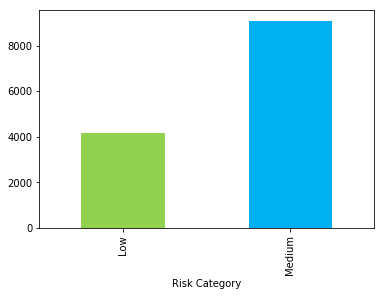

Risk Category,Low,Medium,Total
Threat Driver,,,
3rd Party Damage (41%),1687.729,484.133,2171.862
External Corrosion (22%),910.398,0.000,910.398
Manufacturing Defect (30%),1545.924,8607.676,10153.600
Total,4144.051,9091.809,13235.860


In [272]:


ross_dat , ross_mat = build_matrix(rossdale, 
             'Total Probability', 
             'Total Consequence', 
             agg='sum')

ross_dat['Threat Driver'] = ((ross_dat[['External Corrosion (22%)',
                                      'Stress Corrosion Cracking (2%)',
                                      '3rd Party Damage (41%)',
                                      'Manufacturing Defect (30%)',
                                      'Construction Threat (5%)']])*np.array([0.22, 0.02, 0.41, 0.30, 0.05])).idxmax(axis=1)


ross_mat = ross_mat.sort_index(ascending=False).rename(index={np.nan:'Total'}).style.apply(risk_matrix, axis=None).set_properties(**{'width': '50px',
                                                                                        'height':'50px',
                                                                                        'border':'1px solid #aaaaaa',
                                                                                        'text-align':'center'}).set_table_styles([{'selector':'th','props':[('border','1px solid #aaaaaa')]}])

green = '#92d050'
blue = '#00b0f0'
yellow = '#ffff00'
red = '#ff0000'

ross_plot = ross_dat.groupby('Risk Category').sum()['Length (m)']
colors = ross_plot.index.map({'Low':green,'Medium':blue,'High':yellow,'Extreme':red}).to_list()
ross_plot = ross_plot.plot(kind='bar', color=colors)
ross_drive = ross_dat.pivot_table(index='Threat Driver', 
                                  columns='Risk Category', 
                                  values='Length (m)',
                                  aggfunc=sum,
                                 dropna=False, margins=True, margins_name='Total',
                                 fill_value=0.00)

display(ross_mat)
display(ross_plot)
plt.show()
display(ross_drive)
# #.to_excel('rossdale_mat.xlsx')


#.background_gradient(cmap='Reds', axis=None)


Risk Category
Low       4144.051
Medium    9091.809
Name: Length (m), dtype: float64

## Worsley

In [60]:
worsley = pd.read_excel('atco_20200430_1437_worsley.xlsx', skiprows=3)

In [62]:
worsley.groupby('Route').agg(['count','sum'])['Length (m)'].sort_values('sum',ascending=False)

,count,sum
Route,,
101-114,2102,19180.22
101-9301,1,8.77
101-301,2,1.86
101-401,2,1.86
101-801,1,1.16
101-601,1,0.50


In [210]:
worsley.columns.to_frame(name='cols').query('cols.str.contains("Manufactu|Consequence")')

,cols
Manufacturing Defect (30%),Manufacturing Defect (30%)
Safety Consequence (46%),Safety Consequence (46%)
Environment Consequence (40%),Environment Consequence (40%)
Economic Consequence (14%),Economic Consequence (14%)
Total Consequence,Total Consequence
Total Probability x Total Consequence,Total Probability x Total Consequence


In [63]:
worsley_lines = ['101-114',
                '101-9301',
                '101-301',
                '101-401',
                '101-801',
                '101-601']
##            '101-122'
##            '101-201',
##            '101-501',
##            '101-9201',
##            '342-1',
##            '95-1',

q = f"""select
        ll.linename,
        ld.code girthweld,
        ps.*
        from pipesegment ps
        join stationseries ss on ps.beginstationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        join listdomain ld on ps.pipegirthwelddomainid = ld.id
        where ll.linename in {str(worsley_lines).replace('[','(').replace(']',')')}"""

wor_gw = oracle_sql(q).groupby('LINENAME').agg({'GIRTHWELD': str_concat2})
wor_gw = wor_gw.rename(columns={'GIRTHWELD':'Pipe Joining Method'}, index={'LINENAME':'Route'})
wor_gw.index.rename('Route', inplace=True)

wor_cp = worsley[['Route','Total Non-Conformance Readings','Total All Readings']].assign(pct_comp = lambda x: x.iloc[:,1]*100./x.iloc[:,2], Compliance = lambda x: x.iloc[:,1].astype(str) +'/'+ x.iloc[:,2].astype(str) + ' - ' + x.pct_comp.round(2).astype(str)+'%').groupby('Route').agg({'Compliance':str_concat2,})

worsley.groupby('Route').agg({
                                'Length (m)':sum,
                                'Installation Year': str_concat2,
                                'MAOP (kPa )': str_concat2,
                                'Class Area': str_concat2,
                                '%SMYS': str_concat3,
                                'Outside Diameter (mm)':str_concat3,
                                'Wall Thickness (mm)': str_concat3,
                                'Grade (MPa)':str_concat3,
                                'Seam Type':str_concat2,
                                'Mainline Coating': str_concat2
                                }).merge(wor_gw, left_index=True, right_index=True).merge(wor_cp, left_index=True, right_index=True)

,Length (m),Installation Year,MAOP (kPa ),Class Area,%SMYS,Outside Diameter (mm),Wall Thickness (mm),Grade (MPa),Seam Type,Mainline Coating,Pipe Joining Method,Compliance
Route,,,,,,,,,,,,
101-114,19180.22,1967,4140,"Class 1, Class 2, Class 3","16.95, 20.4, 30.6",114.00,"3.2, 4.8","241, 290","ERW, UNK","Wax, YJ","ELEC, UNK","0/0 - nan%, 0/1 - 0.0%, 0/1509 - 0.0%, 0/2 - 0.0%, 0/290 - 0.0%, 0/96 - 0.0%"
101-301,1.86,1967,4140,Class 1,"16.95, 20.4",114.00,4.8,"241, 290","ERW, UNK",Unknown,ELEC,0/0 - nan%
101-401,1.86,1967,4140,Class 1,"16.95, 20.4",114.00,4.8,"241, 290","ERW, UNK",Unknown,ELEC,0/0 - nan%
101-601,0.50,1967,4140,Class 1,20.4,114.00,4.8,241,UNK,Unknown,ELEC,0/0 - nan%
101-801,1.16,1967,4140,Class 3,15.41,59.94,3.91,206,UNK,Unknown,UNK,0/0 - nan%
101-9301,8.77,1967,4140,Class 1,15.38,60.00,3.9,207,UNK,Unknown,ELEC,0/0 - nan%


Consequence Category,Negligible,Marginal,Significant,Severe,Total
Likelihood Category,,,,,
Likely,2,0,0,0,2
Somewhat Likely,5,0,0,0,5
Somewhat Unlikely,261,34,0,0,295
Not Likely,1380,427,0,0,1807
nan,1648,461,0,0,2109


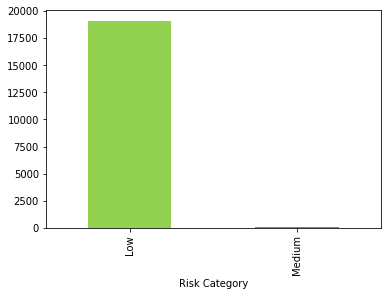

Risk Category,Low,Medium,Total
Threat Driver,,,
3rd Party Damage (41%),13207.830,0.000,13207.830
External Corrosion (22%),1966.528,0.000,1966.528
Manufacturing Defect (30%),3933.754,86.258,4020.012
Total,19108.112,86.258,19194.370


In [268]:


wor_dat, wor_mat = build_matrix(worsley, 
             'Total Probability', 
             'Total Consequence', 
             agg='count')

wor_dat['Threat Driver'] = ((ross_dat[['External Corrosion (22%)',
                          'Stress Corrosion Cracking (2%)',
                          '3rd Party Damage (41%)',
                          'Manufacturing Defect (30%)',
                          'Construction Threat (5%)']])*np.array([0.22, 0.02, 0.41, 0.30, 0.05])).idxmax(axis=1)

wor_mat = wor_mat.sort_index(ascending=False).style.apply(risk_matrix, axis=None).set_properties(**{'width': '50px',
                                                                                            'height':'50px',
                                                                                            'border':'1px solid #aaaaaa',
                                                                                            'text-align':'center'}).set_table_styles([{'selector':'th','props':[('border','1px solid #aaaaaa')]}])

# wor_dat.groupby('Risk Category').count().Route

green = '#92d050'
blue = '#00b0f0'
yellow = '#ffff00'
red = '#ff0000'

wor_plot = wor_dat.groupby('Risk Category').sum()['Length (m)']
colors = wor_plot.index.map({'Low':green,'Medium':blue,'High':yellow,'Extreme':red}).to_list()
wor_plot = wor_plot.plot(kind='bar', color=colors)
wor_drive = wor_dat.pivot_table(index='Threat Driver', 
                                  columns='Risk Category', 
                                  values='Length (m)',
                                  aggfunc=sum,
                                 dropna=False, margins=True, margins_name='Total',
                                 fill_value=0.00)

display(wor_mat)
display(wor_plot)
plt.show()
display(wor_drive)


#.to_excel('rossdale_mat.xlsx')


#.background_gradient(cmap='Reds', axis=None)


# This section is trying to get the start and end GPS coordinates for each pipeline

In [259]:


q = f"""select
        sub.*
        
        from
        (select ll.id, ll.linename, ld.code, ps.pipelinesystemname, ss.id as ssid, ss.beginstationnum, ss.endstationnum, b.bendlatitude, b.bendlongitude, b.stationnum from StationSeries ss
        join lineloop ll on ss.lineloopid = ll.id
        join pipelinesystem ps on ll.pipelinesystemid = ps.id
        join listdomain ld on ll.linelooptypeld = ld.id
        
        join bend b on b.stationseriesid = ss.id
        
        where ll.linename in {str(worsley_lines).replace('[','(').replace(']',')')}) sub
        order by sub.LINENAME asc, sub.beginstationnum asc, sub.STATIONNUM asc
        """

temp = oracle_sql(q).query("LINENAME.isin(@rossdale)|LINENAME.isin(@worsley)")

temp.loc[temp.groupby('LINENAME').STATIONNUM.idxmax().append(temp.groupby('LINENAME').STATIONNUM.idxmin())].sort_values(['LINENAME','STATIONNUM'])

del temp
# print(str(worsley).replace('[','(').replace(']',')'))


# highlight worsley rows
#.style.apply(lambda x: ["background: red" if 'WORSLEY' in x.loc['PIPELINESYSTEMNAME'] else "" for v in x], axis=1)

In [269]:
q = f"""select
        ll.linename,
        ld.code girthweld,
        ps.*
        from pipesegment ps
        join stationseries ss on ps.beginstationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        join listdomain ld on ps.pipegirthwelddomainid = ld.id
        where ll.linename in {str(worsley_lines).replace('[','(').replace(']',')')}"""

oracle_sql(q).groupby('LINENAME').agg({'GIRTHWELD': str_concat2 })

,GIRTHWELD
LINENAME,
101-114,"ELEC, UNK"
101-122,UNK
101-201,ELEC
101-301,ELEC
101-401,ELEC
101-501,"ELEC, UNK"
101-601,ELEC
101-801,UNK
101-9201,UNK
